Notebook to train and analyze a Mixture of Experts architecture using label split on the default mnist dataset. Two experts are trained, one on the digits of \[0, 4\] and one on \[5, 9\]. An 'unknown' label is added to take other labels into account. Each expert is trained on a dataset containing the respective labels and a subset of the other dataset as unknown samples. In a second step a gating network is trained on a training set containing all ten digits and evaluated on the combined validation data from the experts.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.mnist.mnist_net import MnistNet
from models.mnist.generic_gating_network import GenericGatingNetwork
from models.mnist.gating_network import GatingNetwork
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset

In [2]:
transformations_mnist_default = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

In [3]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [4]:
# Preparing mnist datasets for all digits
mnist_dataset = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_train, mnist_valid = train_test_split(mnist_dataset, [0.8, 0.2])
mnist_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

# Preparing mnist datasets for digits in [0, 4]
mnist_train_bottom = build_subset(mnist_train, [i for i in range(5)])
mnist_valid_bottom = build_subset(mnist_valid, [i for i in range(5)])

# Preparing mnist datasets for digits in [5, 9]
mnist_train_top = build_subset(mnist_train, [i for i in range(5, 10)])
mnist_valid_top = build_subset(mnist_valid, [i for i in range(5, 10)])

In [5]:
# Adding unknown samples from the respective other dataset
mnist_train_bottom_fraction, _ = train_test_split(mnist_train_bottom, [0.2, 0.8])
mnist_train_top_fraction, _ = train_test_split(mnist_train_top, [0.2, 0.8])
mnist_valid_bottom_fraction, _ = train_test_split(mnist_valid_bottom, [0.2, 0.8])
mnist_valid_top_fraction, _ = train_test_split(mnist_valid_top, [0.2, 0.8])

mnist_train_bottom_unknown = torch.utils.data.ConcatDataset([mnist_train_bottom, mnist_train_top_fraction])
mnist_valid_bottom_unknown = torch.utils.data.ConcatDataset([mnist_valid_bottom, mnist_valid_top_fraction])

mnist_train_top_unknown = torch.utils.data.ConcatDataset([mnist_train_top, mnist_train_bottom_fraction])
mnist_valid_top_unknown = torch.utils.data.ConcatDataset([mnist_valid_top, mnist_valid_bottom_fraction])

In [6]:
bottom_expert = MnistNet(classes=[i for i in range(5)], unknown_class=True)
bottom_expert.load_state_dict(torch.load('./trained_models/label_split_semi_unknown_class/mnist_bottom_expert.pth'))
# bottom_expert.fit(
#     training_data=mnist_train_bottom_unknown,
#     validation_data=mnist_valid_bottom_unknown,
#     num_epochs=20,
#     batch_size=128,
#     device=device,
#     criterion=criterion,
#     optimizer=optimizer,
#     learning_rate=0.0005,
#     save_state_path='./trained_models/label_split_semi_unknown_class/mnist_bottom_expert.pth'
#     )

upper_expert = MnistNet(classes=[i for i in range(5, 10)], unknown_class=True)
upper_expert.load_state_dict(torch.load('./trained_models/label_split_semi_unknown_class/mnist_upper_expert.pth'))
# upper_expert.fit(
#     training_data=mnist_train_top_unknown,
#     validation_data=mnist_valid_top_unknown,
#     num_epochs=20,
#     batch_size=128,
#     device=device,
#     criterion=criterion,
#     optimizer=optimizer,
#     learning_rate=0.0005,
#     save_state_path='./trained_models/label_split_semi_unknown_class/mnist_upper_expert.pth'
#     )

<All keys matched successfully>

In [7]:
gate = GatingNetwork(classes=[i for i in range(10)], experts=[bottom_expert, upper_expert])

In [8]:
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.0534, 'acc': 0.9852, 'entropy': 0.1509}

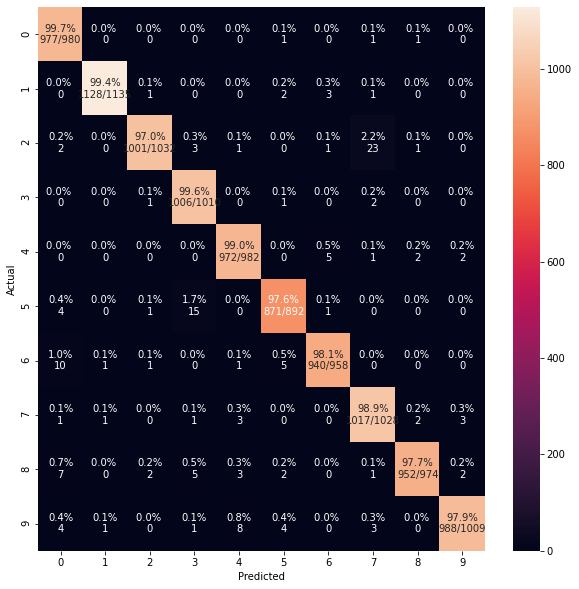

In [9]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [10]:
gate.load_state_dict(torch.load('./trained_models/label_split_semi_unknown_class/gate.pth'))
# gate.fit(
#     training_data=mnist_train, 
#     validation_data=mnist_valid, 
#     num_epochs=20, 
#     batch_size=128, 
#     device=device, 
#     criterion=criterion, 
#     optimizer=optimizer, 
#     learning_rate=0.00005, 
#     save_state_path='./trained_models/label_split_semi_unknown_class/gate.pth'
#     )

<All keys matched successfully>

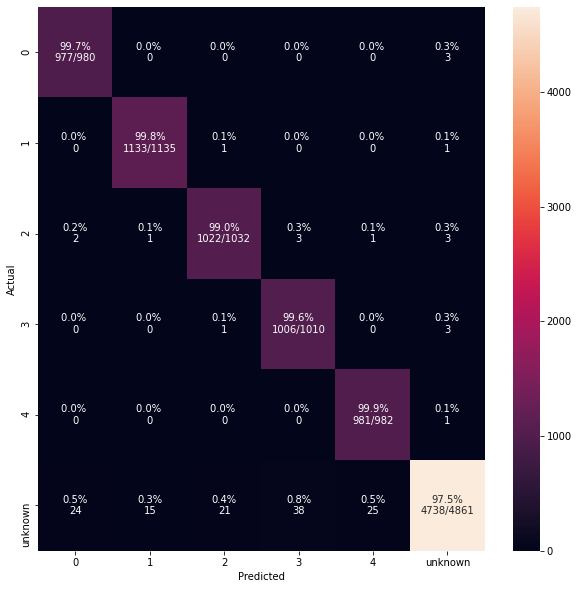

In [11]:
y_pred = bottom_expert.predict(mnist_test, device)
y_true = mnist_test.targets
y_true = ['unknown' if label in [i for i in range(5, 10)] else label for label in y_true]
plot_confusion_matrix(y_true, y_pred, [str(i) for i in range(5)] + ['unknown'])

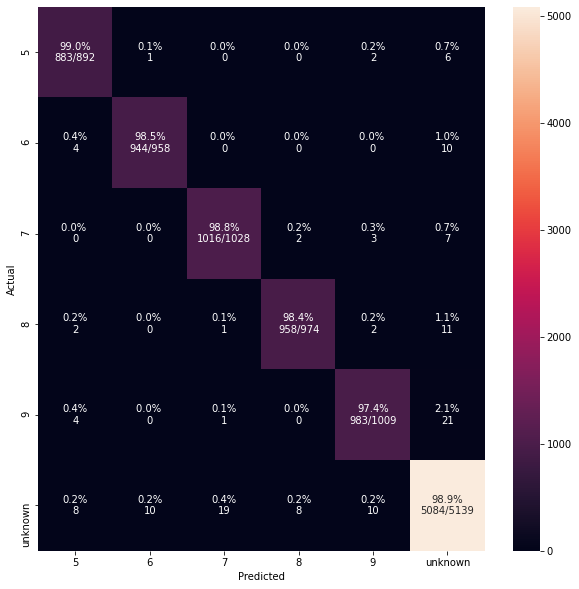

In [12]:
y_pred = upper_expert.predict(mnist_test, device)
y_true = mnist_test.targets
y_true = ['unknown' if label in [i for i in range(5)] else label for label in y_true]
plot_confusion_matrix(y_true, y_pred, [str(i) for i in range(5, 10)] + ['unknown'])

In [13]:
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.0351, 'acc': 0.9888, 'entropy': 0.0747}

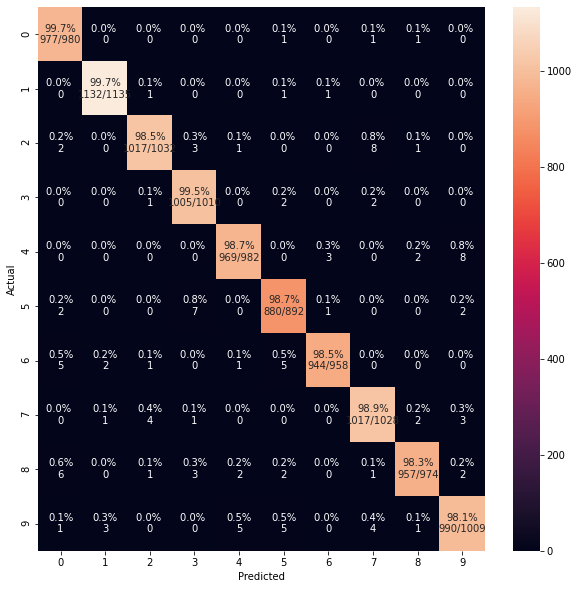

In [14]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])